## BloomTech Data Science

---


# Ridge Regression
- Do one-hot encoding of categorical features
- Use scikit-learn to fit Ridge Regression models



In [6]:
 # Model Building
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [4]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [5]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [7]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created').sort_index()
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.05)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop high-cardinality categorical variables
  cutoff = 5
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [8]:
df.head()

,bathrooms,bedrooms,latitude,longitude,price,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,...,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,
2016-04-01 22:12:41,1.0,1,40.7302,-73.9924,3195,high,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:56:00,1.0,0,40.7576,-73.9677,2000,medium,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-04-01 22:57:15,2.0,3,40.7388,-73.9851,5850,high,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-01 23:26:07,1.0,1,40.7939,-73.9738,2745,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1
2016-04-02 00:48:13,1.0,1,40.7784,-73.9491,2400,medium,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49026 entries, 2016-04-01 22:12:41 to 2016-06-29 21:41:47
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             49026 non-null  float64
 1   bedrooms              49026 non-null  int64  
 2   latitude              49026 non-null  float64
 3   longitude             49026 non-null  float64
 4   price                 49026 non-null  int64  
 5   interest_level        49026 non-null  object 
 6   elevator              49026 non-null  int64  
 7   cats_allowed          49026 non-null  int64  
 8   hardwood_floors       49026 non-null  int64  
 9   dogs_allowed          49026 non-null  int64  
 10  doorman               49026 non-null  int64  
 11  dishwasher            49026 non-null  int64  
 12  no_fee                49026 non-null  int64  
 13  laundry_in_building   49026 non-null  int64  
 14  fitness_center        49026 non-nul

# II. Split Data

Split **target vector** from **feature matrix**.

In [10]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [11]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [12]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3565.095561112848
Baseline MAE: 1203.9726810650523


# IV. Build Models

Combine transformers and predictor with `Pipeline`.

In [13]:
# Step 1: Import your transformer class
# We did above ☝️

# Step 2: Instantiate your transformer
# ohe = OneHotEncoder(use_cat_names=True)

# Step 3: Fit your transformer to the TRAINING data
# ohe.fit(X_train)

# Step 4: Transform my training and test data
# XT_train = ohe.transform(X_train)
# XT_test = ohe.transform(X_test)

Ridge regression (regularization)

In [14]:
# model_r = Ridge(alpha=1.0)
# model_r.fit(XT_train, y_train)

Ridge()

In [15]:
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=1.0)
)
model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], use_cat_names=True)),
                ('ridge', Ridge())])

# V. Check Metrics

In [17]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge training MAE: 672.0351683623255
Ridge test MAE: 675.6640925954134


# VI. Tune Model

** Interlude: How do you know what the best hyperparameter values are? **

In [22]:
alphas = np.arange(1.0, 20.5, 0.5)

train_mae = []
test_mae = []


for a in alphas:
  model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=a) # HYPERPARAMETER
  )
  model_r.fit(X_train, y_train)
  train_mae.append(mean_absolute_error(y_train, model_r.predict(X_train)))
  test_mae.append(mean_absolute_error(y_test, model_r.predict(X_test)))


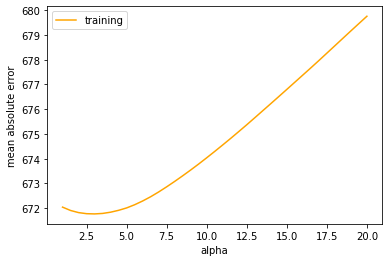

In [25]:
plt.plot(alphas, train_mae, color='orange', label='training')
# plt.plot(alphas, test_mae, color='blue', label='test')
plt.xlabel('alpha')
plt.ylabel('mean absolute error')
plt.legend();

# VII. Communicate results

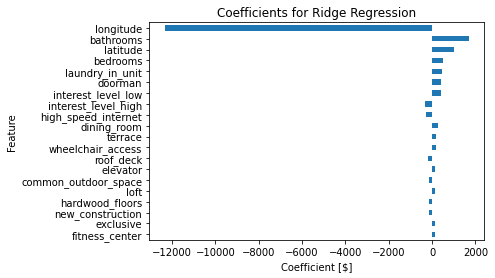

In [19]:
coefficients = model_r.named_steps['ridge'].coef_
features = model_r.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');